### CS6493 Natural Language Processing: Assignment 2

Name: Shiwei Chen | Contact: shiwechen6-c@my.cityu.edu.hk

#### Question 1 - RNN & LSTM

(**20 marks**) Recurrent neural network (RNN) is a widely used model in NLP since it can process any length input. However, RNN unfortunately suffers from vanishing/exploading gradient and long-term dependency. To this end, Long Short-Term Memory (LSTM) is proposed to address these problems. The Figure 1 illustrate the architecture of LSTM.

<center>
    <figure>
        <img src="https://upload.wikimedia.org/wikipedia/commons/4/40/LSTM.jpg" width="325" height='250'>
        <figcaption>Figure 1: Overview of LSTM.</figcaption>
    </figure>
</center>

**Q1a.** Briefly explain why RNN suffers from vanishing/exploding gradient and long-term dependency. (**4 marks**)

**My answer:** It is the intrinsic nature of RNN itself and its training method, Backpropagation. Say we are dealing a time series with $T$ steps, to train an RNN using Backpropagation, we need to unroll our network such that it becomes a feed-forward network made of $T$ duplicates of the original network. In such circumstance:
- Firstly, The unrolled network is usually very deep because time series is usually very long. When we backpropogate the gradients we have to sums up all previous contribution until the current one: $$\frac{\partial L}{\partial W}=\sum_{i=0}^T \frac{\partial \mathcal{L}_i}{\partial W} \propto \sum_{i=0}^T \bigg(\prod_{i=k+1}^y \frac{\partial h_i}{\partial h_{i-1}}\bigg)\frac{\partial h_k}{\partial W}$$It is immediately obvious to notice from the equation that the problems resides in the product of the ratio of hidden states $\prod\frac{\partial h_i}{\partial h_{i-1}}$:
    - **Vanishing Gradient:** When $\Vert\frac{\partial h_i}{\partial h_{i-1}}\Vert_2 < 1$, the product goes to $0$ exponentially fast, meaning the information of **long-term dependencies** is lost. 
    - **Exploding Gradient:** When $\Vert\frac{\partial h_i}{\partial h_{i-1}}\Vert_2 > 1$, the product goes to $\infty$ exponentially fast, hindering the network to learn with long sequences.
- Furthermore, By design of the RNN, the unrolled network contains $T$ duplicates of the same original networks, meaning that the weight matrix is reused for every layers. When calculating the gradient, multiplying the same weight term many times is making the problems described above more severe than that in a normal feed-forward network.

**Q1b.** Can LSTM solve the problem of vanishing and exploding gradient? Explain the reasons. (**4 marks**)

**My answer:** To my understanding, the default LSTM does not completely solve but greatly alleviate the problem. Let's say we want to calculate the dependency between time steps $t'$ and $t$ by taking the derivatives and applying the chain rule:
- For the vanilla RNN will hidden states $h$: $$\frac{\partial h_{t'}}{\partial h_t} = \prod_{k=1}^{t'-t} w\sigma'(wh_{t'-k}) = w^{t'-t}\prod_{k=1}^{t'-t}\sigma'(wh_{t'-k})$$For the LSTM with cell state $s$: $$\frac{\partial s_{t'}}{\partial s_t} = \prod_{k-1}^{t'-t}\sigma(v_{t+k})$$
- The above equations show that both vanilla RNN and LSTM indeed will suffer from Vanishing Gradient problem since they both use sigmoid as activation function. However the difference is:
    - For vanilla RNN, its gradient decays with $w\sigma'(\cdot)$.
    - For LSTM, its gradient decays with only $\sigma(\cdot)$, and most importantly, unlike the vanilla RNN, there is a set of weights which can be learned such that $\sigma(\cdot) \approx 1$, which means the the graident can be neither vanishing nor exploding.
- In short, I think that the LSTM is in fact having a much more slower speed of gradient decay/explosion than that of the vanilla RNN and thus have a much better performance on learning Long-term Dependecies in time series related tasks.
- During my self-exploration on this topic online, I found out that it is related Constant Error Carousel in the original paper described the vanilla LSTM. I might have to look into that later.

**Q1c.** An advantage of RNN/LSTM is that the model size does not increase for longer inputs. Given a LSTM cell where the input and output dimensions are repectively $d_i$ and $d_o$, please calculate the number of parameters of this LSTM cell. (**4 marks**)

**My answer:** Following the defined procedure of a LSTM cell:
- The input vector concatenate with the output from the previous cell: $d_o + d_i$.
- For each feed-forward neural network (with a bias vector of size $d_o$) the concatenate input goes through: $d_o*(d_o+d_i)+d_o$.
- There are 4 feed-forward neural networds in a LSTM cell (1 for forget-gate, 2 for input-gate, and 1 for output gate), therefore the total number of parameters in a LSTM cell is: $4*[d_o*(d_o+d_i)+d_o]$.

**Q1d.** The following code snippet builds a typical classification model with LSTM. In specific, this model is comprised of an *Embedding* layer, a *LSTM* layer, and a linear *decoder*. Please calculate the total number of the parameters of this model. Provide your calculation process. (**8 marks**)
```Python
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self, vocab_size=1000, 
                 embedding_dim=10,
                 hidden_size=20, 
                 num_class=5):
        super(MyModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            bidirectional=True,
                            num_layers=1)
        self.decoder = nn.Linear(hidden_size, num_class, bias=True)

model = MyModel()
```

**My answer:** There are totally three layers in this model:
- Embedding Layer: Given $\text{vocab\_size}=1000$ and $\text{embedding\_dim}=10$, meaning that this layer is going to transform a vector of size $1000$ into a vector of size $10$, then the totol number of parameters is the size of the weight matrix that can do this job: which is of size $10*1000 = 10000$.
- BiLSTM Layer: Given $\text{input\_size}=10$ and $\text{output\_size}=\text{hidden\_size}=20$, using the formula obtained in the previous question, the total number of parameters is $2*4*[20*(20+10)+20] = 8*620 = 4960$.
- The Linear Layer: Given $\text{num\_class}=5$, meaning that the output of the BiLSTM layer of size $20$ will be transformed into size $5$ as the network output, then the total number of parameters is $(20+1)*5 = 105$, where the $1$ accounts for biases.

Therefore the total number of parameters is $10000+4960+105 = 15065$.

#### Question 2 - Attention & Transformer

(**20 marks**) A critical weakness of RNNs is that they cannot parallelize the computation. In contrast, the **Attention** mechanism perfectly solve this problem. Given the query matrix $Q$, and a set of key-value pairs ${K, V}$, we formulate the scaled dot-produc attention as $$\operatorname{Attention}(Q,K,V)=\operatorname{softmax}(\frac{QK^T}{\sqrt{d_k}})V$$where $d_k$ is the hidden size.

**Q2a.** List at least two advantages and two disadvantages of attention mechanism compared to RNN. (**4 marks**)

**My answer:** 
Advantages:
- The Attention mechanism can identify the most important and related information in an input for accomplishing a particular task. In the encoder-decoder structure, the decoder-RNN needs to extract information from the final state of the encoder-RNN, which by definition should contain all information of previous states. This is a hard task itself as it is subject to ambiguity and loss so the Attention mechanism alleviates this bottleneck by telling the decoder where to look.
- Extended from the above point, the Attention mechanism captures the the global-vs-local relationship at once, unlike RNN, which is completely dependent on previous inputs/states.
- Moreover, the outputs of the Attention Mechanism are independent, meaning that it can be made paralleled (Multi-head), which further improves the capacity of capturing critical information.

Disadvantages:
- In contrast to lecture slides (Page 20 Pretraining-1), I think for global attention it can be computationally expensive since it introduce at least $O(N)$ time of computation but maybe it reduces the overall cost of the model? I am not quite sure here.
- It required Positional Encoding to handle spacetime relationship in the input.
- Its weights tend to be sparse and prone to focus on the *most* important information and thus ignoring the second or third most important information. This also implies that if it looks at the wrong place initially then what follows it can be useless (Solved by Multi-head).
- It is kind of unsupervised or indirectly supervised by the labels. The loss propagate backward will first affect the attention's output then to its parameters. The explainability of the knowledge the Attention model harnessed may be ambiguous or even inexplicable.

**Q2b.** To implement the attention, we first calculate the attention scores, i.e. similarities, between the query and each key. Then we normalize the attention scores to be between 0 and 1 using softmax. However, the equation says that we need to scale the multiplication with the factor $\frac{1}{\sqrt{d_k}}$ before the normalization. Please mathematically demonstrate why this scaling factor is introduce. (**8 marks**)

**My answer:** In Scaled Dot-Product Attention, we want the output to be standard normalized so that the network is more robust, meaning that the output of the Attention should have mean of $0$ and a variance of $1$. Consider two $d_k\times d_k$ size matrices $Q$ and $K$ consisting of independent random variables, then the matrix multiplication $QK$ has a mean of 
$$\begin{align*} 
    \mathbb{E}\bigg[\sum_{i=0}^{d_k}Q_{1,i}K_{i,1}\bigg] &= \sum_{i=0}^{d_k}\mathbb{E}\big[Q_{1,i}K_{i,1}\big] \text{\:\:\:since\:} \mathbb{E}[X+Y]=\mathbb{E}[X]+\mathbb{E}[Y] \text{\:if\:} X \perp \!\!\! \perp Y \\
                                                         &= \sum_{i=0}^{d_k}\mathbb{E}\big[Q_{1,i}\big]\mathbb{E}\big[K_{i,1}\big] = 0 \text{\:\:\:since\:} \mathbb{E}[XY]=\mathbb{E}[X]\mathbb{E}[Y]=0 \text{\:if\:} X \perp \!\!\! \perp Y
\end{align*}$$ 
which has met the requirement and a variance of
$$\begin{align*}
    \operatorname{Var}\bigg(\sum_{i=0}^{d_k}Q_{1,i}K_{i,1}\bigg) &= \sum_{i=0}^{d_k}\operatorname{Var}\big(Q_{1,i}K_{i,1}\big) \\
                                                                 &= \sum_{i=0}^{d_k} 1 = d_k \text{\:\:\:since\:} \operatorname{Var}(XY) = \mathbb{E}[X^2]\mathbb{E}[Y^2] - \mathbb{E}[X]^2\mathbb{E}[Y]^2 = 1 \text{\:if\:} X \perp \!\!\! \perp Y
                                                                 
\end{align*}$$
which means the standard deviaion is $\sqrt{d_k}$ and thus need to be normalized by the scaling term $\frac{1}{\sqrt{d_k}}$.


**Q2c.** Transformer has achieved impressive performance on various NLP tasks, including some sequence-to-sequence tasks, like machine translation and response generation. We generally solve these seq2seq tasks in the auto-regressive paradigm. This paradigm can be easily implemented with LSTM since it can sequentially encode and decode the tokens. However, the Transformer is essentially not a sequential model since it receives all input tokens once a time. So, a question is naturally raised - which part of Transformer is designed to solve the auto-regressive problems and how it works? Figure 2 illustrates the architecture of Transformer. Please give your answer. (**8 marks**)

<center>
    <figure>
        <img src="https://www.researchgate.net/profile/Kenton-Murray/publication/336617830/figure/fig1/AS:815110255804416@1571348837446/Architecture-of-the-Transformer-Vaswani-et-al-2017-We-apply-the-auto-sizing-method.ppm" width="225" height='350'>
        <figcaption>Figure 2: Overview of transformer.</figcaption>
    </figure>
</center>

**My answer:** The Positional Encoding is piece of information that the model uses to keep track of the order information about the input. I will try to summarize my understanding of it as follow.

So the intended goal of Positional Encoding (hereinafter referred as PE) is to incorporate the order of words in an input sentence with the following constraints:
- Most obviously, PE should deterministically output an unique encoding for each word's position in a sentence.
- The distance between any two position after the encoding should be consistent across different length of input sentences, meaning that we cannot assign encoding simply in a bounded range (i.e. $[0, 1]$) because the delta-distance changes along with different length of input.
- The encoding should be able to generalize to inputs that are longer than training samples with no further effort needed, meaning that we cannot assign encoding linearly (i.e. $PE_0 = 0, PE_1=1, \dots$).
- The "encoding strength" (the length of the PE vector added on top of the word embedding vector) should be just right. If it is too strong, it will overtoning the semantic relationships erasing the effort of word embedding. If it is too weak then the model barely gets enough hints about the order information.

To satisfy the above constraints, we encode each position as a vector of sinusoids, which forms a geometric progression as the frequency decreases (as the figure in page 12 Lecture 5 Pre-training-2 described): 
$$\begin{align*}
    \operatorname{PE}_{pos,2i} &= \sin(\frac{1}{10000^{\frac{2i}{d_k}}}*pos) \\
    \operatorname{PE}_{pos,2i+1} &= \cos(\frac{1}{10000^{\frac{2i+1}{d_k}}}*pos)
\end{align*}$$
where $pos$ is the index of the word and $i \in [0,\dots,\frac{d_k}{2})$ is the $i$-th element of the PE vector.

#### Question 3 - Pre-training

(**30 marks**) We can generally divide existing pre-train models into three categories, namely **Encoder-based model**, **Decoder-based model**, and **Encoder-Decoder model** according to the model architecture.

Encoder-based models, such as BERTs, employ a bidirectional Transformer encoder to predict the masked words. These models obtain all input tokens once a time and simultaneously encode them. Therefore, encoder-based models are also called **auto-encoding** models. Decoder-based models, such as GPTs, use a left-to-right Transformer to predict a text sequence word-by-word. At each stage, a token can only access to its leftward tokens. Therefore, this kind of models are called **auto-regressive** models. Encoder-Decoder models, such as T5 and BART, combining the features of encoder-based models and decoder-based models, consist of a bidirectional Transformer encoder and a unidirectional decoder.

For the NLP tasks, we cal also divide them into two parts, namely natural language understanding (NLU) tasks, and natural language generation (NLG) tasks. The NLU tasks, such as text classification and sequence labeling, usually requires the model to understand the context and then make classification on the sentence or token level. In contrast, the NLG tasks, such as generative summarization and response generation, requires the model to predict the target sequence word-by-word based on the given context.

**Q3a.** Please respective answer and explain whether encoder-based/decoder-based/encoder-decoder pretrain models are a good choice fro NLU and NLG tasks. (**6 marks**)

**My answer:**
- Encoder-based models can be generally described as models that converts human-understandable data into computer-understandable data. For example, the vanilla BERT itself is pre-trained to capture the "meaning" of a word in the context. This is just intuitive for NLU tasks, which is defined as *Converting chunks of text into more formal representations that are easier for computer program to manipulate*, according to Wikipedia.
    - However, there exist tricks that a specific Encoder-based model can use to generalized to NLG tasks. For example, the Masked Language Modeling tasks can be modified as predicting masked tokens in an auto-regressive manner for BERT to be able to generate texts. 
- In contrast to NLU, NLG is defined as *Converting information from computer databases or semantic intents into readable Human Languages*, according to Wikipedia. Decoder-based models, such as GPTs, are the natural pick for this task, as they are designed to process in an auto-regressive manner, which is the same as how humen generate texts (speak, write, type...).
- For the Encoder-Decoder-based models, broadly speaking I think that they are qualified for both NLU and NLG as they consists of at least one encoder and one decoder. However, to be more exact, I believe NLG should be the native task since the outputs are from the decoder part. To tune them for NLU tasks may required some tricks or techniques.

**Q3b.** The bidirectionality nature makes BERT difficult to be applied to NLG tasks. To address this problem, Dong et al., proposed a unified pre-trained language model (UNILM) which consists of a multi-layer Transformer encoder, but it can be applied to both NLG and NLU tasks. In this word, they introduced four pre-training objectives, namely unidirectional LM, bidirectional LM, sequence-to-sequence LM and next sentence prediction. In specific,
- Unidirectional LM: Predict the randomly masked token only using the leftward context and itself.
- Bidirectional LM: Predict the randomly masked token using the whole context.
- Sequence-to-sequence LM: In this mode, we generally need to distinguish two segments, i.e., source segment and target segment. For the randomly masked token in target segment, we predict them using the whole source segment. For the randomly masked token in target segment, we predict it using the whole source segment and its leftward tokens in target segment.
- Next sentence prediction: It is same as the NSP in Bert.
These pre-training objectives can be simply implemented by different mask strategies. Given two masked segments - source segment "Birt [Mask] activities" and target segment "He was [Mask] to jail", please fill the value in the following table 1 to show how the masks should be designed for the three language modeling pre-training objectives. (**15 marks**)

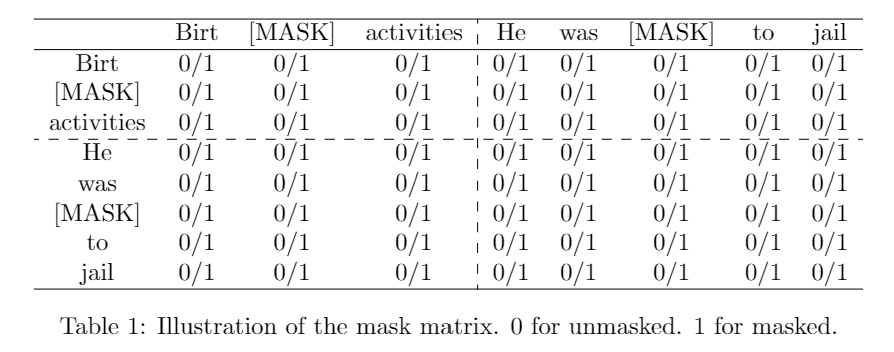

**My answer:**
For the unidirectional LM, it is just a diagonal mask:
$$\begin{array}{cccc:ccccc}
    \hline
    & \text{Birt} & \text{[MASK]} & \text{activities} & \text{He} & \text{was} & \text{[MASK]} & \text{to} & \text{jail} \\
    \hline
    \text{Birt} & 0 & 1 & 1 & 1 & 1 & 1 & 1 & 1 \\
    \text{[MASK]} & 0 & 0 & 1 & 1 & 1 & 1 & 1 & 1 \\
    \text{activities} & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 \\
    \hdashline
    \text{He} & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \\
    \text{was} & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 \\
    \text{[MASK]} & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\
    \text{to} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
    \text{jail} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \hline
\end{array}$$

For the bidirectional LM, same as BERT, all tokens should attend:
$$\begin{array}{cccc:ccccc}
    \hline
    & \text{Birt} & \text{[MASK]} & \text{activities} & \text{He} & \text{was} & \text{[MASK]} & \text{to} & \text{jail} \\
    \hline
    \text{Birt} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \text{[MASK]} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \text{activities} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \hdashline
    \text{He} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \text{was} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \text{[MASK]} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \text{to} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \text{jail} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \hline
\end{array}$$

For the seq2seq, the source segment should all attend  (assuming bi-RNN encoder), and target segment follows the unidirectional LM pattern:
$$\begin{array}{cccc:ccccc}
    \hline
    & \text{Birt} & \text{[MASK]} & \text{activities} & \text{He} & \text{was} & \text{[MASK]} & \text{to} & \text{jail} \\
    \hline
    \text{Birt} & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 \\
    \text{[MASK]} & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 \\
    \text{activities} & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 1 \\
    \hdashline
    \text{He} & 0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 \\
    \text{was} & 0 & 0 & 0 & 0 & 0 & 1 & 1 & 1 \\
    \text{[MASK]} & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\
    \text{to} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
    \text{jail} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    \hline
\end{array}$$

**Q3c.** Implement three functions for these masking strategies. (**9 marks**)

**My answer:**

In [2]:
import numpy as np
import torch


def mask_for_unidirectional_lm(source_seg, target_seg):
    """
    Uni-directional masking for UniLM.

    :param source_seg: the source input text segment of type string
    :param target_seg: the target input text segment of type string
    :return: a mask of size (len(source_seg+target_seg), len(source_seg+target_seg)) and of type torch.tensor
    """
    L = len(source_seg) + len(target_seg)
    

def mask_for_bidirectional_lm(source_seg, target_seg):
    pass

def mask_for_seq2seq_lm(source_seg, target_seg):
    pass

#### Reference
    [1] Dong, Li, Nan Yang, Wenhui Wang, Furu Wei, Xiaodong Liu, Yu Wang, Jianfeng Gao, Ming Zhou, and Hsiao-Wuen Hon. "Unified language model pre-training for natural language understanding and generation." Advances in Neural Information Processing Systems 32 (2019).


#### Question 4 - Question Answering

(**30 marks**) There are two famous and popular public datasets for QA tasks, i.e., **SQuAD v1.1**[1] and **SQuAD v2.0**[2]. A major differences between these two datasets is that the v2.0 extends the v1.1 problem definition by allowing for the possibility that no answer exists in the provided paragraph, making the problem more realistic.

For the QA task proposed in v1.1, we represent the input question and the passage as a single packed sequence. Then, we introduce a start vector $S \in \mathbb{R}^H$ and an end vector $E \in \mathbb{R}^H$ during fine-tuning where $H$ is the hidden size. The probability of word $i$ being the start of the answer span is computed as a dot product between $T_i$ and $S$ followed by a softmax over all of the words in the paragraph: $$P_i = \frac{e^{S\cdot T_i}}{\sum_j e^{S\cdot T_i}}$$where $T_i$ is the embedding of $i$-th word. The analogous formula is used for the end of the answer span. The score of a candidate spans from poistion $i$ to poisition $j$ is defined as $S\cdot T_i + E\cdot T_j$, and the maximum scoring span where $j\geq i$ is used as a prediction.

**Q4a.** For the QA task defined in v2.0, it additionally introduce a set of questions that have no answers. However, the approach to v1.1 much predict an answer to each question, which conflicts with the task in v2.0. Please extend the BERT-based approach to v1.1 to address this problem. Elaborate your design and the workflow of your proposed approach. (**15 marks**)

**My answer:**

**Q4b.** The approaches to QA tasks, such as BiDAF and BERT, are essentially to find the boundaries of the answer spans. However, Bert, which is pre-trained with masked language modeling (MLM) and next sentence prediction (NSP), just learns token-level and sentence-level information, instead of involving any span information during the pre-training stage. Therefore, we probably can say that the pre-training objectives of original BERT are not very good choices for QA tasks. Please design your pre-training objectives for BERT to fit in QA tasks, and other span-based tasks, like coreference resolution[3].

**My answer:**

#### Reference

    [1] Rajpurkar, P., Zhang, J., Lopyrev, K. and Liang, P., 2016, November. SQuAD: 100,000+ Questions for Machine Comprehension of Text. In Proceedings of the 2016 Conference on Empirical Methods in Natural Language Processing.
    [2] Rajpurkar, P., Jia, R. and Liang, P., 2018, July. Know What You Don’t Know: Unanswerable Questions for SQuAD. In Proceedings of the 56th Annual Meeting of the Association for Computational Linguistics.
    [3] Lee, K., He, L., Lewis, M. and Zettlemoyer, L., 2017, September. End-to-end Neural Coreference Resolution. In Proceedings of the 2017 Conference on Empirical Methods in Natural Language Processing.

--------------------END OF FILE--------------------